<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Alan Contreras Montanares


### **Link de repositorio de GitHub:** `https://github.com/AlanMontanares/MDS7202`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes_data.csv')
df.head(4)


,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?. 

In [2]:
!pip install xgboost


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier


X = df.drop('Diabetes', axis=1)
y = df['Diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Los modelos basados en arboles de desicion NO necesitan normalizacion
#Aun asi se uso SimpleImputer para que tuviera al menos un procesamiento en caso de existir celdas vacias

numeric_features = X.select_dtypes(include=['float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

model = XGBClassifier()

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

classification_rep = classification_report(y_test, y_pred)

print('Classification Report:\n', classification_rep)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.71      0.74      7090
         1.0       0.73      0.79      0.76      7049

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



Por lo general, se puede ver que tiene una Presicion adecuada en ambas clases, esto da cuenta de que el modelo es un predictor relativamente bueno de diabetes.

La Precision  proporciona información sobre cuántas de las instancias clasificadas como positivas realmente lo son, en comparación con el total de instancias clasificadas como positivas por el modelo. Una clase con una Precision del 100% indicaria que si el modelo predice una entrada como esa clase significaria que lo mas probable es que asi sea. No es recomendable usarlo con clases desbalanceadas.

El Recall mide la proporción de instancias positivas reales que fueron correctamente clasificadas por el modelo entre el total de instancias positivas reales, es decir, es la tasa de verdaderos positivos. Un Recall del 100% en una clase indicaria que todas las muestras de esa clase fueron clasificadas correctamente por el modelo.

El F1-Score es una combinacion entre las metricas anteriores para evaluar con mas robustez el desempeño de un modelo. Como esta en funcion de la Precision, no es recomendable usarlo con clases desbalanceadas.

Sin embargo, estas metricas no sirven en nada para ver que caracteristicas aportan informacion relevante al modelo para el problema que se este abordando, ya que solo realizan una comparacion entre las predicciones y target, pero no la relacion que tiene el imput con el target o el modelo como tal.


## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

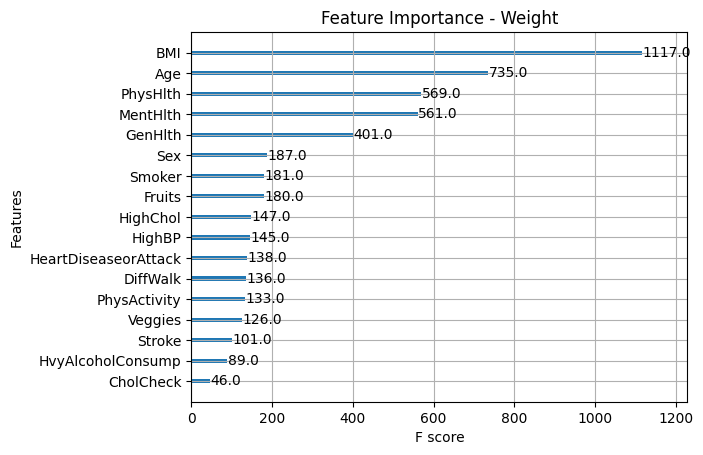

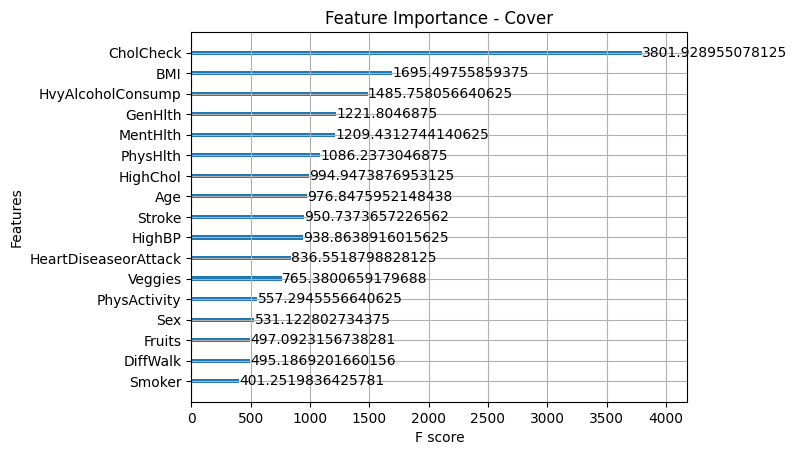

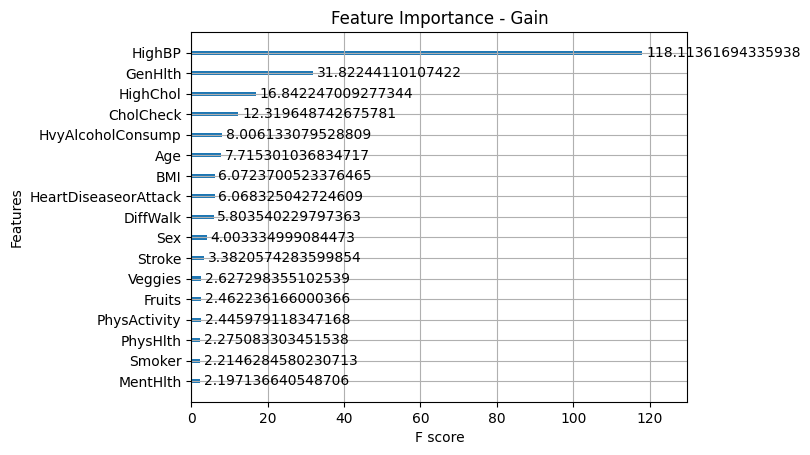

In [60]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

clf = XGBClassifier()
clf.fit(X_train, y_train)

plot_importance(clf, importance_type='weight')
plt.title('Feature Importance - Weight')
plt.show()

plot_importance(clf, importance_type='cover')
plt.title('Feature Importance - Cover')
plt.show()

plot_importance(clf, importance_type='gain')
plt.title('Feature Importance - Gain')
plt.show()

Las importancias son distintas ya que la funcion objetivo de cada metodo es distinto.

 - **weight** es el numero de veces que una caracteristica aparece en un arbol
 - **gain** es la ganancia promedio de las divisiones que utilizan la característica
 - **cover** es la cobertura promedio de las divisiones que utilizan la característica, donde la cobertura se define como el número de muestras afectadas por la división

En este caso la caracteristica BMI es usada muchas veces en los arboles durante el entrenamiento, es por eso que tiene el maximo **weight**, sin embargo tiene menor ganancia que la caracteristica HighBP, esto da cuenta de que la caracteristica HighBP es más informativa que BMI y ayuda al modelo a tomar decisiones más acertadas (todo respecto a la mejora de la funcion objetivo). Por otro lado la caracteristica CholCheck tiene mayor covertura que estas dos, que a diferencia de la ganancia, indica que la característica es relevante para un conjunto sustancial de datos y tiene un impacto importante en la partición de las muestras.

Ahora bien, para seleccionar caracteristicas estos metodos tienen problemas, uno de ellos es que en los modelos que utilizan arboles de desicion las importancias se calculan en función del número de veces que se utiliza una característica para dividir un nodo en un árbol de decisión (agregando que por ejemplo en Random Forest esta seleccion es al azar). Si bien puede ser una medida útil de la importancia de una característica para la precisión global del modelo, esto puede inducir a error en el caso de características con muchos valores posibles, ya que estas características pueden utilizarse con más frecuencia simplemente porque hay más oportunidades de dividirlas.

Por otro lado, esta seleccion de caracteristicas es en base a este unico modelo (metodo Wrapper), por lo que no implicaria que las mejores caracteristicas encontradas aca sirvan para otros modelos.


## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

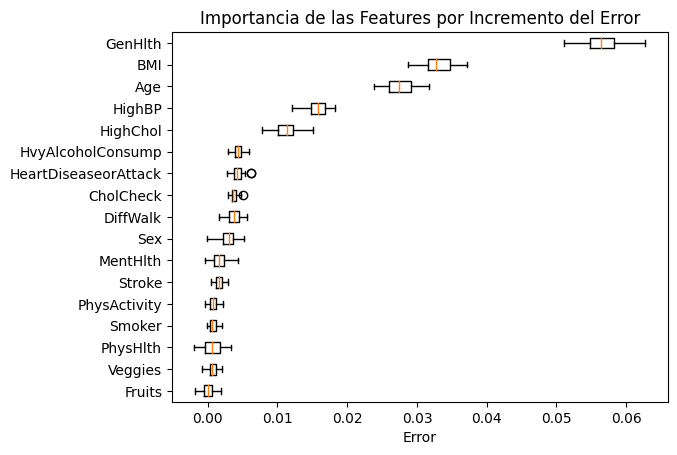

In [5]:
from sklearn.inspection import permutation_importance

result = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=42)

perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

La desviacion estandat proporciona una medida de la variabilidad en los resultados obtenidos al permutar las características. En otras palabras, señala cuánto varían las importancias de las características cuando se realizan múltiples permutaciones. Por ejemplo, si la desviación estándar es alta, indica que las importancias de las características varían considerablemente entre las permutaciones. Esto puede deberse a la sensibilidad del modelo a diferentes configuraciones de datos y sugiere que la interpretación de la importancia de las características podría ser menos confiable.

In [6]:
result["importances_std"]

array([0.0021241 , 0.00115049, 0.00156482, 0.00052973, 0.00218419,
       0.00056679, 0.00080717, 0.00060332, 0.00079242, 0.00077325,
       0.00077103, 0.00276211, 0.00109811, 0.00139095, 0.00100195,
       0.0006267 , 0.00143055])

La propuesta mide la importancia de las características mediante permutación. Calcula la diferencia en la métrica de rendimiento entre el modelo original y el modelo con las características permutadas. Cuanto mayor sea la diferencia, más importante se considera la característica.

Las features con mayor impacto son: 
 - GenHlth
 - BMI
 - Age
 - HighBP
 - HighChol

Esto en parte tiene sentido ya que estas estaban en los primeros lugares de los graficos anteriores, por lo que era de esperarse que estuvieran en posiciones altas de importancia.

En este caso, más que cambiar las conclusiones respecto a los resultados anteriores cambian la selecciones de caracteristicas, debido a que este es un metodo mas robusto, generalizable e interpretable, agregando que tiene en cuenta la interacción entre las características.

**Ventajas**
 - No necesita re-entrenar el modelo: A diferencia de algunos métodos que requieren el reentrenamiento del modelo, la permutación se puede realizar en un modelo ya entrenado. Esto puede ser beneficioso cuando el entrenamiento del modelo es costoso o consume tiempo.
 - Alta comprensión de interpretabilidad global: El método de permutación proporciona una comprensión global de la importancia de las características, ya que evalúa su impacto en el modelo en su conjunto. Esto es especialmente útil para comprender qué características son relevantes para la predicción global del modelo.
 - Toma en cuenta las interacciones: Al permutar las características, el método de permutación puede capturar de manera implícita las interacciones entre características, proporcionando así una evaluación más completa de la importancia de las características.

**Desventajas**
 - Si las características están altamente correlacionadas y se permuta una de ellas, el modelo puede experimentar cambios poco realistas que no reflejan la relación genuina entre las características.
 - Si se agrega una nueva característica altamente correlacionada con una característica existente, la importancia de la característica original podría disminuir, ya que parte de la información se distribuiría entre las dos características correlacionadas. Esto podría conducir a una interpretación sesgada de la importancia de las características.
 - Enlazado al error del modelo: La permutación está vinculada al rendimiento del modelo original, y si el modelo tiene errores significativos, la medida de importancia también puede verse afectada. Si el modelo tiene un rendimiento deficiente, las importancias de las características también pueden no reflejar correctamente su contribución real.


## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [7]:
!pip install shap


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [9]:
import shap

explainer = shap.TreeExplainer(pipeline["classifier"])
shap_values = explainer(X)
shap_values

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[17:58:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


.values =
array([[-1.268375  , -0.00460456, -0.3848604 , ..., -0.08242669,
        -0.01611218,  0.49607968],
       [ 0.2021631 ,  0.05632673,  0.14292245, ..., -0.05447157,
         0.07768462,  0.4162888 ],
       [ 0.91174173,  0.31258932, -0.297469  , ..., -0.06976558,
        -0.02217249, -0.64350384],
       ...,
       [-0.2627788 , -0.08597348,  0.28478292, ...,  0.29957864,
        -0.01806796,  0.47976932],
       [ 0.3048206 , -0.1685042 ,  0.33939835, ...,  0.26907772,
        -0.02126826,  0.58223975],
       [ 0.17443807,  0.03591182,  0.23616262, ..., -0.0959989 ,
        -0.03462881,  0.53356117]], dtype=float32)

.base_values =
array([-0.00636337, -0.00636337, -0.00636337, ..., -0.00636337,
       -0.00636337, -0.00636337], dtype=float32)

.data =
array([[ 4.,  1.,  0., ...,  0.,  0.,  1.],
       [12.,  1.,  1., ...,  0.,  1.,  1.],
       [13.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [13.,  0.,  1., ...,  1.,  0.,  1.],
       [11.,  0.,  1., ...,  1.,  0.

Cada número en el resultado de los Shapley values representa la contribución individual de una característica específica a la diferencia entre la predicción del modelo para la observación en cuestión y la predicción media (valores base) del modelo para todas las observaciones.

Si se le puede atribuir un significado a la positividad y negatividad de cada valor:
 - Un valor de shapley positivo indica que la presencia de esa característica está contribuyendo a elevar la predicción por encima de la predicción media (valor base) del modelo.
 - Un valor de shapley negativo indica que la presencia de esa característica está contribuyendo a disminuir la predicción por debajo de la predicción media del modelo.

Cabe recalcar que sin el valor base, sería difícil saber si un valor SHAP es positivo o negativo

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

In [10]:
idx = 1

shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values.values[idx,:], 
                X.iloc[idx,:],
                link="logit")

In [11]:
idx = 9

shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values.values[idx,:], 
                X.iloc[idx,:],
                link="logit")

In [12]:
idx = 150

shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values.values[idx,:], 
                X.iloc[idx,:],
                link="logit")

Efectivamente existen variables que aportan positiva/negativamente la deteccion de diabetes en el modelo, por ejemplo, para la primera instancia HighBP aporta positivamente, mientras que BMI aporta negativamente. Lo mismo para las otras instancias.

Con 3 datos no es tan directo encontrar un patron general, pero de igual forma se puede ver que para las 3 instancias el BMI es uno de los que más aporta negativamente, mientras que el GenHlth y Sex aportan positivamente. El resto depende de la persona ya que por ejemplo el HighBP aporta positivamente para la instancia 150 pero negativamente para la instancia 9.

Como se mencionó, este analisis es exclusivo de cada instancia y los patrones encontrados son exclusivos de estas 3 instancias en particular, por lo que no es generalizable para todo el dataset. Sin embargo se puede analizar el impacto o interpretabilidad global usando *summary_plot*.

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

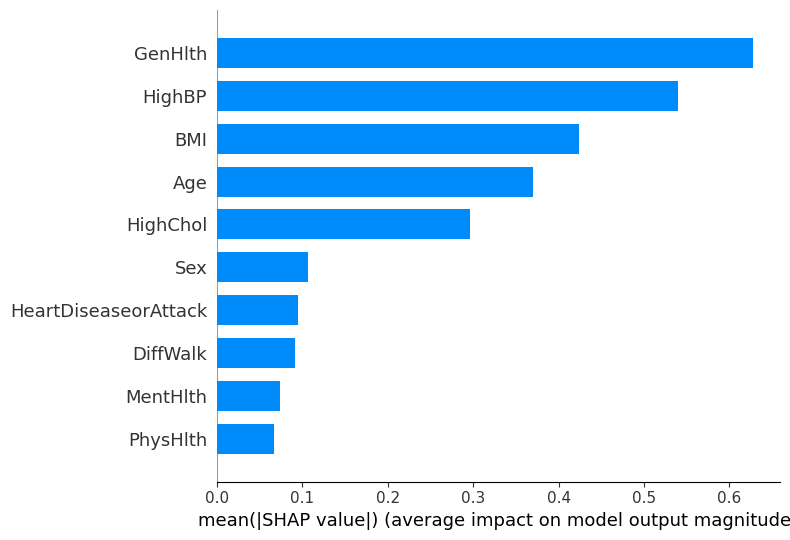

In [13]:
shap.summary_plot(shap_values, X, plot_type="bar", max_display=10)

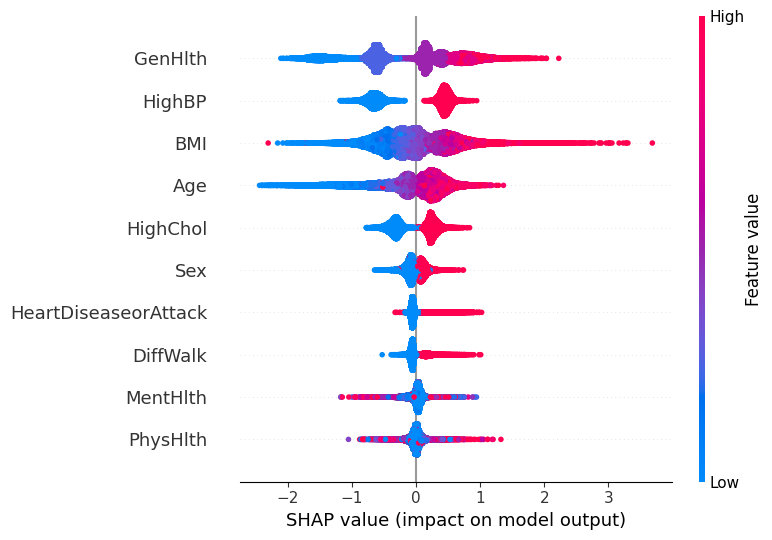

In [14]:
shap.summary_plot(shap_values, X, max_display=10)

Del aporte de cada feature a nivel global se puede observar que GenHlth, HighBP, BMI, etc., son las mejores caracteristicas encontradas por este metodo. Al ver el grafico de puntos se puede ver que a modo general, a valores grandes de HighBP aportan positivamente la prediccion, mientras que a valores pequeños su aporte es negativo, gracias a esto podemos observar lo mismo que se habia visto en instancias particulares pero esta vez a todo el dataset.

La diferencia entre el analisis de instancias con esto es que se puede ver de forma general la relacion entre los aportes positivos/negativos respecto a los valores de cada caracteristica, debido a que en las instancias podiamos tener valores que aportasen positivamente pero esto no implicaba que fuese asi para todo el dataset, por lo que analizarlos iba a dar conclusiones sesgadas y no generales.

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [15]:
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

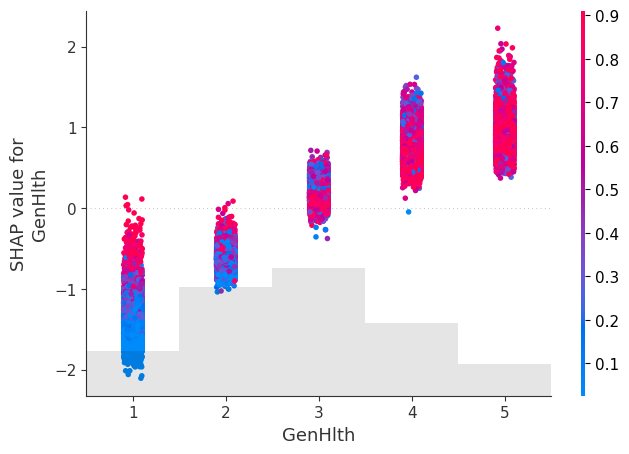

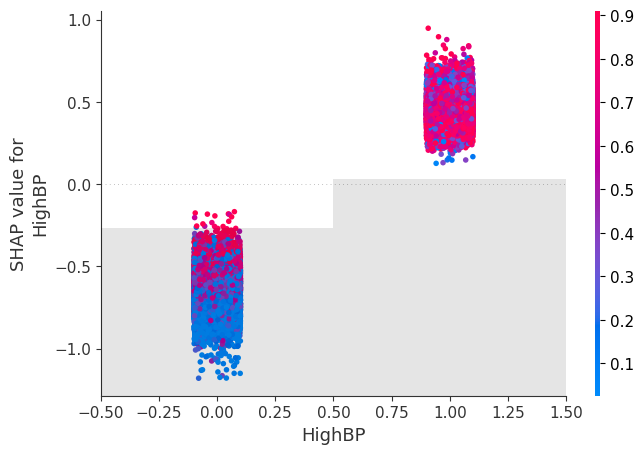

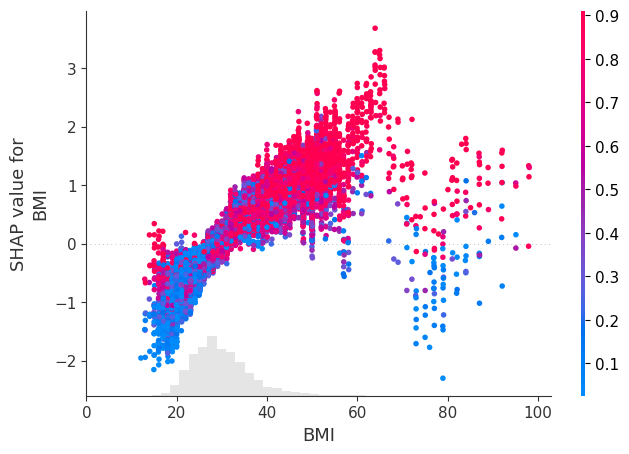

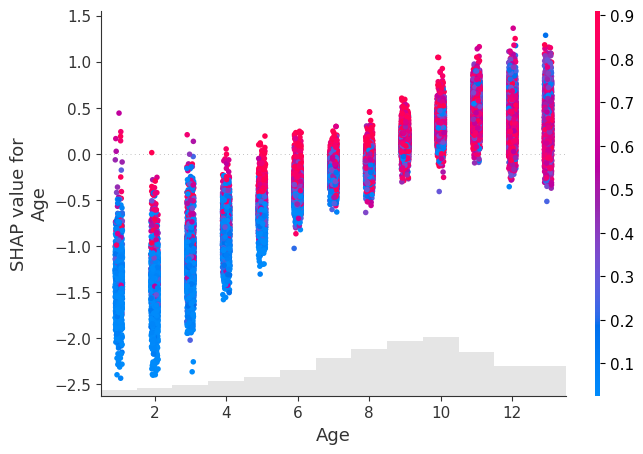

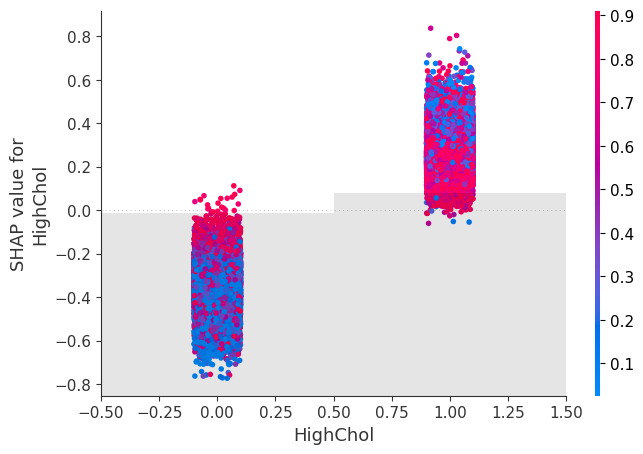

In [16]:
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]
probabilidades = pipeline.predict_proba(X)[:,1]

for name in feature_importance_names[:5]:
    shap.plots.scatter(shap_values[:,name], 
                       color=probabilidades, xmin=0)    

Se puede ver que a medida que los valores de las caracteristicas son mayores los valores SHAP tienden a ser positivos, y a su vez, las probabilidades de tener diabetes tambien comienzan a subir. Sin embargo esto no se cumple para todos los casos pero si para cierta mayoria, debido a que se pueden apreciar estas tendencias.

Un ejemplo más claro serian los de HighBP y HighChol, los cuales presentan esta tendencia, pero es más difuso con la caracteristica BMI, en donde al aumentar el valor aumenta la probabilidad de tener diabetes y tambien aumentan los valores SHAP, pero solo en un rango, ya que si aumentan aun mas, las se tienen probabilidades altas y bajas, lo mismo con los valores SHAP.

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

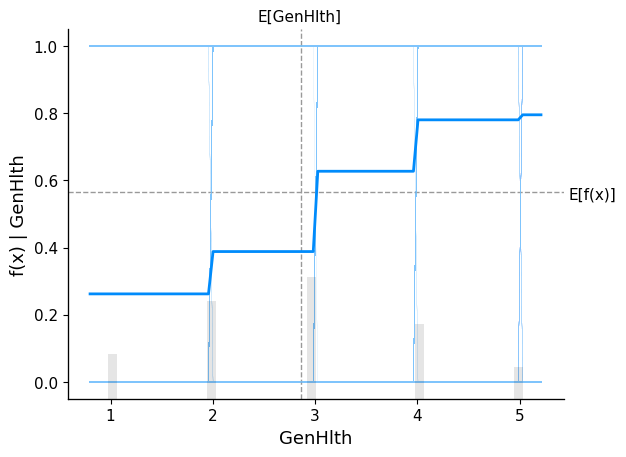

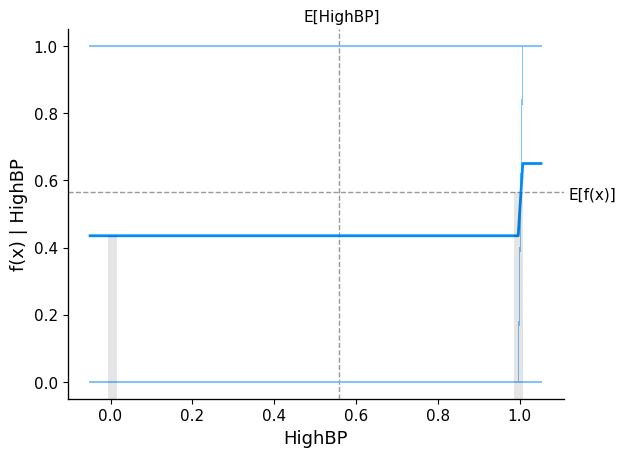

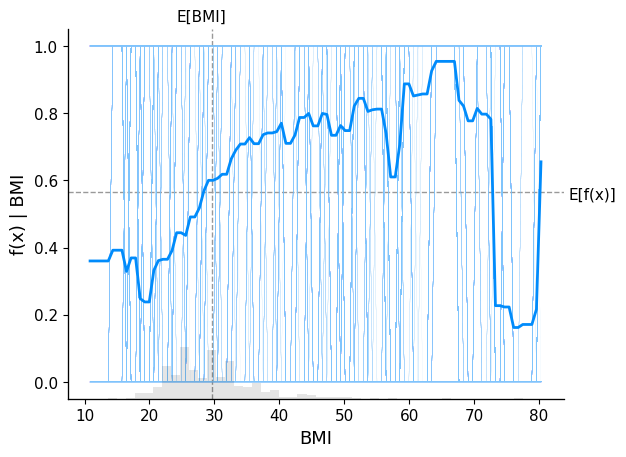

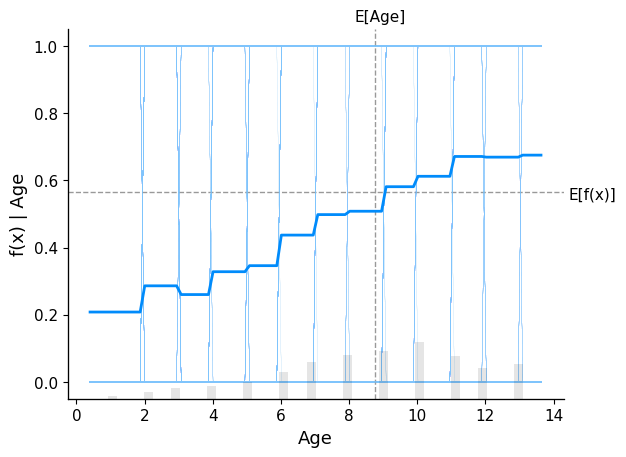

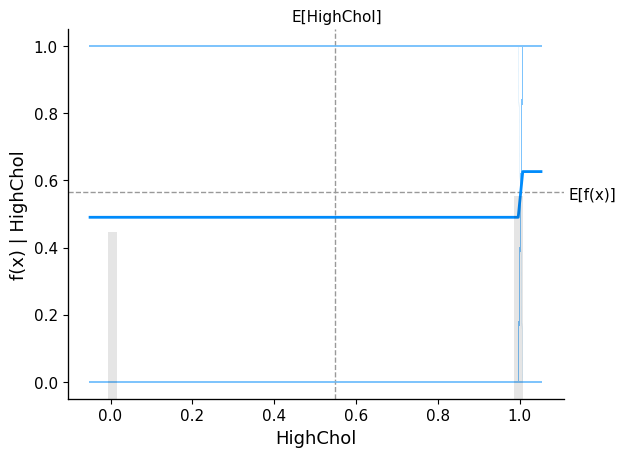

In [56]:
X1000 = shap.utils.sample(X, 1000)

for name in feature_importance_names[:5]:
    shap.partial_dependence_plot(
        name, pipeline.predict, X1000, model_expected_value=True,
        feature_expected_value=True, ice=True,
    )

En esta ocasion se puede ver que para estas caracteristicas el valor esperado del modelo oscila en torno a las sub-categorias de cada clase con ciertas tendencias que se han hablado en las secciones anteriores, como por ejemplo que a mayores valores de una caracteristica hacia que los valores SHAP fueran positivos y a su vez un aumento en la probabilidad de predicciones, y es lo que se observa en estos graficos. 

Ahora bien, como tambien se habló, la caracteristica BMI tenia la peculiaridad de que en un cierto rango las probabilidades aumentaban, pero al exceder este rango se perdia en parte interpretabilidad debido a que habian tanto datos que eran predichos como diabetes como no, y es precisamente lo que se observa en este caso, que luego de que BMI fuese mayor a 70 las probabilidades fluctuan entorno al valor esperado. 

Es importante tener en cuenta que los PDPs representan tendencias promedio en la submuestra de datos que se este utilizando, por lo que estas conclusiones pueden no ser completamente generalizables para todo el conjunto de datos, especialmente si hay interacciones complejas entre variables. Sin embargo, los PDPs proporcionan una buena visión general de las relaciones entre las variables y la salida del modelo.

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [18]:
!pip install alibi


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
from alibi.explainers import AnchorTabular

2023-11-21 17:58:27,183	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [48]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

predict_fn = lambda x: clf.predict(x)
explainer = AnchorTabular(predict_fn, clf.feature_names_in_, seed=1)
explainer.fit(X_train.to_numpy())
class_names = ["No Diabetes","Diabetes"]

idx = 1000
explanation = explainer.explain(X_test.to_numpy()[idx])
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print("")

idx = 3001
explanation = explainer.explain(X_test.to_numpy()[idx])
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print("")

idx = 5751
explanation = explainer.explain(X_test.to_numpy()[idx])
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print("")

Prediction:  Diabetes
Anchor: Age > 11.00 AND HeartDiseaseorAttack > 0.00 AND BMI > 25.00
Precision: 0.98
Coverage: 0.03

Prediction:  Diabetes
Anchor: GenHlth > 2.00 AND BMI > 33.00 AND HighBP > 0.00
Precision: 0.97
Coverage: 0.14

Prediction:  No Diabetes
Anchor: BMI <= 25.00 AND GenHlth <= 2.00 AND HighBP <= 0.00
Precision: 1.00
Coverage: 0.11



En este caso, se tiene que para estos 3 anchors, se logro una covertura demasiado baja, lo cual no es útil ya que solo explica las predicciones del modelo para un pequeño número de puntos de datos. Sin embargo, la precision es muy alta, por lo que a pesar de tener baja covertura, es muy probable de ser exacta y útil para comprender las predicciones del modelo.

En otras palabras, esto podría ser indicativo de que el anchor es muy específico y preciso al explicar las predicciones, pero no es lo suficientemente amplio como para incluir una gama más amplia de datos, por lo que se está perdiendo una parte significativa de las instancias porque el anchor es demasiado restrictivo.

Por otro lado, un anchor con alta precisión pero baja cobertura podría proporcionar explicaciones muy detalladas pero no representativas de toda la gama de casos, por lo que en esta situacion seria ideal preferir un balance entre precisión y cobertura para obtener explicaciones más completas y generalizables. Aunque esto tambien depende del problema, su complejidad y los datos que se tengan.

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> En esta ocasion, las mejores conclusiones fueron obtenidas al usar SHAP, debido a que se pudo analizar los casos de forma general como especifica, y dentro de lo especifico tambien se pudo hacerlo a diversos niveles, como por ejemplo en instancias particulares como tambien en cada una de las caracteristicas en histogramas (scatter plot). A diferencia de los metodos usados por el mismo clasificador o el metodo agnostico global, los cuales solo muestran de forma global una interpretacion de las caracteristicas.

> Por otro lado, usar SHAP puede ser beneficioso en algunos casos en los que se tengan clases de mayor interes, por ejemplo en una clasificacion binaria se podria estar más interesado en poder predecir una clase sobre la otra, y como SHAP entrega una interpretacion de importancias tambien en las clases, esto podria ser usado para seleccionar de mejor manera las caracteristicas para que el modelo se ajuste de mejor manera a la clase de interes.

> Ahora bien, la eleccion del metodo para este problema dependerá tambien de cómo quiere ser abordado, ya que ambos se usan para un modelo dado, esto implica que no necesariamente las intepretaciones sean las mismas al usar otro modelo, o incluso con otros hiperparametros. A pesar de eso, se pudo intepretar de mejor manera los resultados con el metodo agnostico local SHAP, agregando que de igual forma con esta herramienta se puede analizar de forma general la intepretacion que este le da al modelo y sus resultados.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>